In [1]:
from CAENpy.CAENDigitizer import CAEN_DT5740_Digitizer
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
digitizer = CAEN_DT5740_Digitizer(0) # Open the connection.

print(digitizer.idn) # Print general info about the digitizer.

CAEN DT5740D digitizer, serial number 31030


In [12]:
def configure_digitizer(digitizer, dc_offset_list, trig_level_list):

	enable_list = [True, True, True, False]  ## groups of 8 channels (1-8, 9-16, 17-24, 25-32)

	digitizer.set_record_length(128)
	digitizer.set_post_trigger_size(50) ## in percent
	digitizer.set_max_num_events_BLT(100)
	digitizer.set_acquisition_mode('sw_controlled')
	digitizer.set_ext_trigger_input_mode('disabled')
	digitizer.enable_channels(enable_list)

	for i in range(4): ##loop over groups
		bloffset = int((1-dc_offset_list[i]) * 2**16)
		digitizer.set_group_DC_offset(i, DAC=bloffset)
		triglev = dc_offset_list[i]*2**12 + trig_level_list[i]
		digitizer.setup_trigger(i, int(triglev))
		digitizer.set_trigger_polarity(channel=i, edge='rising') 


Reading 17 events....


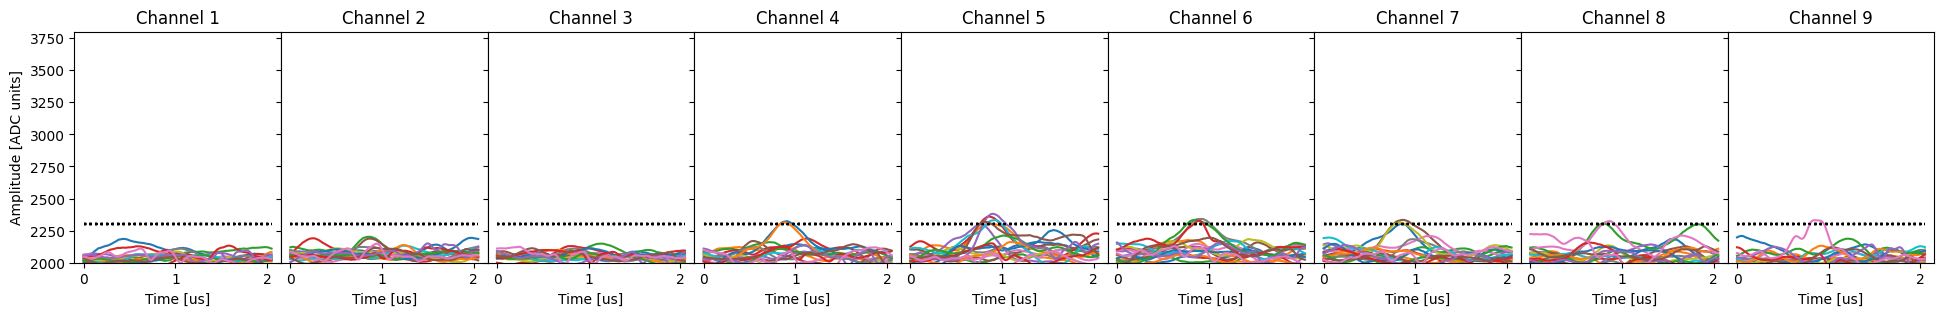

In [18]:
dc_offset_list = [0.5, 0.5, 0.5, 0.5] ## list of dc offsets (fractional range 0-1)
										## e.g. if you want baseline at 25% of max ADC, set 0.25 here
trig_level_list = [250, 250, 250, 250] ## list of trig levels in ADC counts above the baseline
										## e.g. if you 100 ADC counts above baseline, set 100 here

# Now configure the digitizer:
configure_digitizer(digitizer, dc_offset_list, trig_level_list)

# Now enter into acquisition mode using the `with` statement:
with digitizer:
	waveforms = digitizer.get_waveforms()

plt.figure(figsize=(24,3))
for wf in waveforms:
	for j, ch in enumerate(range(16,-1,-2)):
		plt.subplot(1,9,j+1)
		plt.plot(wf['time']*1e6, wf[ch])
		plt.ylim(2000, 3800)
		if(j > 0): 
			plt.gca().set_yticklabels([])
		else:
			plt.ylabel("Amplitude [ADC units]")
		plt.title("Channel %d"%(j+1))
		plt.xlabel("Time [us]")

		gidx = int(j/4)
		trig_lev = dc_offset_list[gidx]*2**12 + trig_level_list[gidx]
		plt.plot(wf['time']*1e6, np.ones_like(wf['time'])*trig_lev, 'k:')

plt.subplots_adjust(wspace=0)
plt.show()